<a href="https://colab.research.google.com/github/srivennela-128/OIB-SIP/blob/main/Project_1_Proposal_Level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab: run in a cell with a leading '!'
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm shap joblib openpyxl --quiet

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload apps.csv or apps.csv.zip from your computer

import pandas as pd
from zipfile import ZipFile
import io

# detect and read
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with ZipFile(io.BytesIO(uploaded[fn])) as z:
            csv_name = [f for f in z.namelist() if f.endswith('.csv')][0]
            df = pd.read_csv(z.open(csv_name))
    else:
        df = pd.read_csv(io.BytesIO(uploaded[fn]))

df.head()

Saving Housing.csv to Housing.csv


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
# basic checks
print(df.columns.tolist())
print(df.isna().mean().sort_values(ascending=False).head(20))  # percent missing
df.describe(include='all').T

['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,545.0,NaN,NaN,NaN,4766729.247706,1870439.615657,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,NaN,NaN,NaN,5150.541284,2170.141023,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,NaN,NaN,NaN,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,NaN,NaN,NaN,1.286239,0.50247,1.0,1.0,1.0,2.0,4.0
stories,545.0,NaN,NaN,NaN,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
mainroad,545,2,yes,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,545,2,no,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basement,545,2,no,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hotwaterheating,545,2,no,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,545,2,no,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np

def clean_housing(df):
    df = df.copy()
    # 1. clean column names
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

    # 2. drop exact duplicates
    df = df.drop_duplicates().reset_index(drop=True)

    # 3. Identify target column (assume 'price' exists)
    if 'price' not in df.columns:
        print("WARNING: no 'price' column found. Please set the correct target.")

    # 4. convert obvious numeric columns
    for col in df.columns:
        if df[col].dtype == 'object':
            # try converting to numeric if many values look numeric
            sample = df[col].dropna().astype(str).head(20).tolist()
            if all(s.replace('.','',1).replace('-','',1).isdigit() for s in sample):
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # 5. common datetime parsing
    for col in df.columns:
        if 'date' in col or 'year' in col and df[col].dtype == object:
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
            except:
                pass

    # 6. simple missing-value strategy (customize later per column)
    # - If column >50% missing, drop (or keep if important)
    missing_frac = df.isna().mean()
    drop_cols = missing_frac[missing_frac > 0.5].index.tolist()
    if drop_cols:
        print("Dropping columns with >50% missing:", drop_cols)
        df.drop(columns=drop_cols, inplace=True)

    # 7. For numeric columns: impute median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())

    # 8. For categorical columns: impute mode
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    for c in cat_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else 'missing')

    # 9. Return cleaned dataframe
    return df

df_clean = clean_housing(df)
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


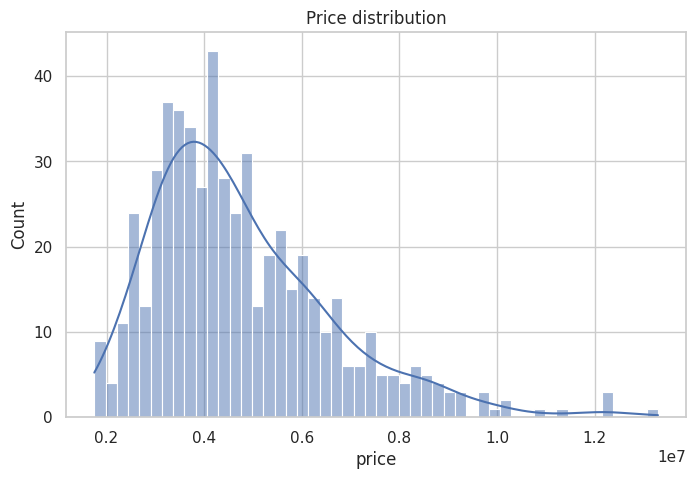

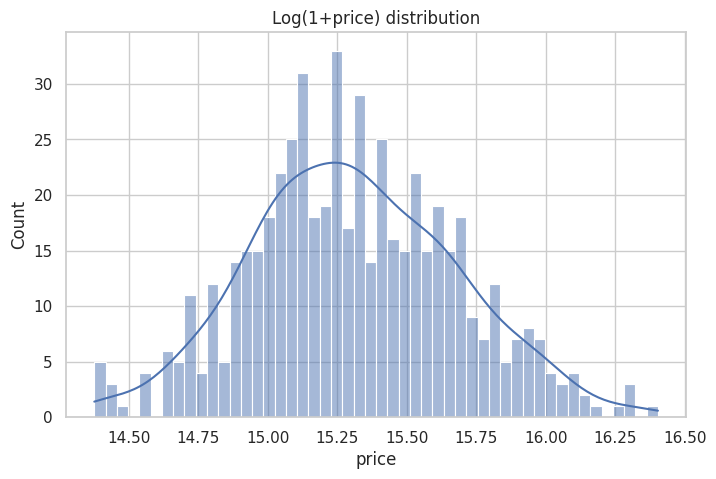

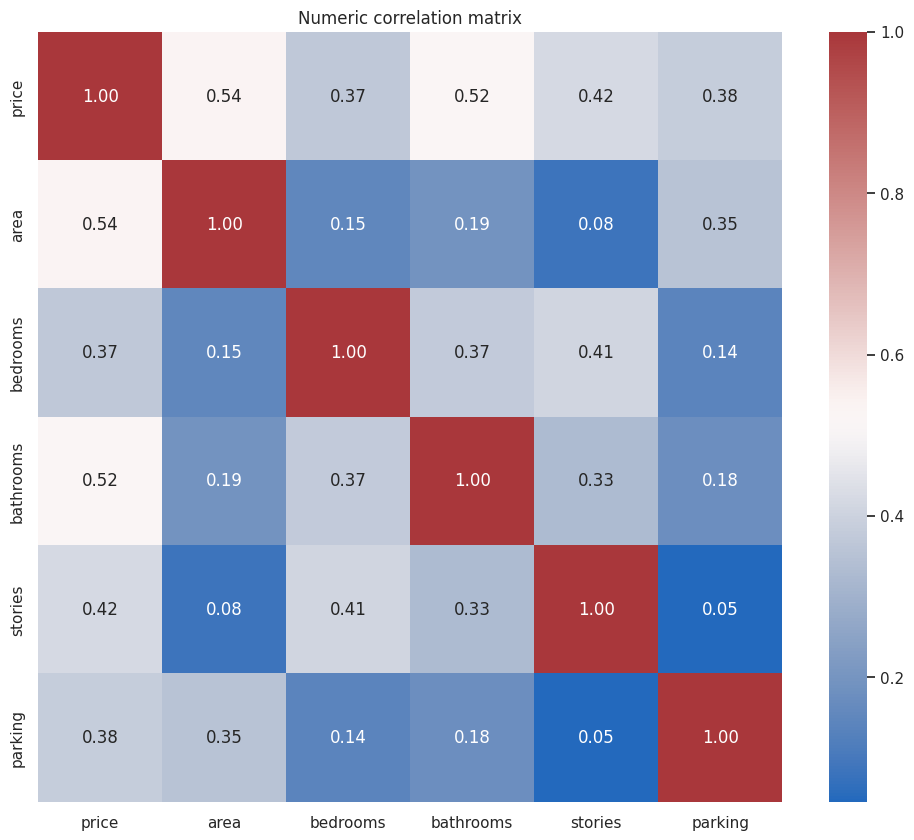

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) target distribution
plt.figure(figsize=(8,5))
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Price distribution')
plt.show()

# If heavily skewed, inspect log1p
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df_clean['price']), bins=50, kde=True)
plt.title('Log(1+price) distribution')
plt.show()

# 2) correlation matrix
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(df_clean[num_cols].corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Numeric correlation matrix')
plt.show()

# 3) price vs sqft / area (replace with your size column name)
if 'sqft' in df_clean.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='sqft', y='price', data=df_clean)
    plt.ylim(0, df_clean['price'].quantile(0.99))
    plt.show()

# 4) top neighborhoods
if 'neighborhood' in df_clean.columns:
    display(df_clean.groupby('neighborhood')['price'].median().sort_values(ascending=False).head(20))


In [ ]:
df_feat = df_clean.copy()

# Identify categorical columns
cat_cols = df_feat.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to numeric (one-hot encoding)
df_feat = pd.get_dummies(df_feat, columns=cat_cols, drop_first=True)

# Log transform price (to reduce skew)
df_feat['log_price'] = np.log1p(df_feat['price'])

df_feat.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,log_price
0,13300000,7420,4,2,3,2,True,False,False,False,True,True,False,False,16.403275
1,12250000,8960,4,4,4,3,True,False,False,False,True,False,False,False,16.321037
2,12250000,9960,3,2,2,2,True,False,True,False,False,True,True,False,16.321037
3,12215000,7500,4,2,2,3,True,False,True,False,True,True,False,False,16.318175
4,11410000,7420,4,1,2,2,True,True,True,False,True,False,False,False,16.250001


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

TARGET = 'log_price'
df_model = df_feat.dropna(subset=[TARGET]).copy()

X = df_model.drop(columns=[TARGET, 'price'], errors='ignore')
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

RMSE: 0.267
R²: 0.631


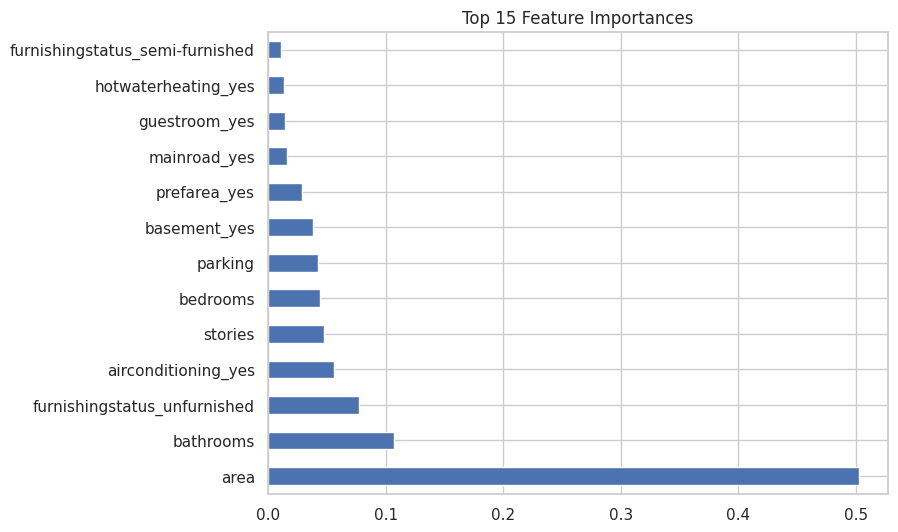

In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
importances.head(15).plot.barh()
plt.title('Top 15 Feature Importances')
plt.show()